In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("../data/fromAPI/combined_data.csv")

/var/folders/xc/x124yzd57d906mgtpgc25wkh0000gn/T/ipykernel_22433/2490449324.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/fromAPI/combined_data.csv")


In [3]:
date_format = "%Y-%m-%d %H:%M:%S"
df["arrival_plan"] = pd.to_datetime(df["arrival_plan"], format=date_format)
df["departure_plan"] = pd.to_datetime(df["departure_plan"], format=date_format)
df["arrival_change"] = pd.to_datetime(df["arrival_change"], format=date_format)
df["departure_change"] = pd.to_datetime(df["departure_change"], format=date_format)
df["departure_plan_hour"] = df["departure_plan"].dt.hour
df["departure_plan_date"] = df["departure_plan"].dt.date

df = df.dropna(subset=["departure_plan"])
df.loc[:, "departure_plan_hour"] = df["departure_plan"].dt.hour
df.loc[:, "departure_plan_datetime"] = (
    df["departure_plan_date"].astype(str) + ' ' +
    df["departure_plan_hour"].astype(str) + ':00:00'
)
df.loc[:, "departure_plan_datetime"] = pd.to_datetime(df["departure_plan_datetime"], format=date_format)

df.head()


,line,path,category,name,state,city,long,lat,arrival_plan,departure_plan,...,departure_delay_m,arrival_delay_check,departure_delay_check,info,arrival_plan_time,arrival_plan_date,departure_plan_time,departure_plan_date,departure_plan_hour,departure_plan_datetime
0,20,Stolberg(Rheinl)Hbf Gl.44|Eschweiler-St.Jöris|...,2,Aachen Hbf,Nordrhein-Westfalen,Aachen,6.091499,50.767800,2024-06-24 00:00:00,2024-06-24 00:01:00,...,0,on_time,on_time,NaN,00:00:00,2024-06-24,00:01:00,2024-06-24,0,2024-06-24 00:00:00
1,18,NaN,2,Aachen Hbf,Nordrhein-Westfalen,Aachen,6.091499,50.767800,NaT,2024-06-24 00:17:00,...,0,on_time,on_time,NaN,NaN,NaN,00:17:00,2024-06-24,0,2024-06-24 00:00:00
2,RE18,NaN,2,Aachen Hbf,Nordrhein-Westfalen,Aachen,6.091499,50.767800,NaT,2024-06-24 00:30:00,...,0,on_time,on_time,NaN,NaN,NaN,00:30:00,2024-06-24,0,2024-06-24 00:00:00
3,1,Hamm(Westf)Hbf|Kamen|Kamen-Methler|Dortmund-Ku...,4,Aachen-Rothe Erde,Nordrhein-Westfalen,Aachen,6.116475,50.770202,2024-06-24 00:03:00,2024-06-24 00:04:00,...,4,on_time,on_time,NaN,00:03:00,2024-06-24,00:04:00,2024-06-24,0,2024-06-24 00:00:00
4,33,Krefeld Hbf|Forsthaus|Anrath|Viersen|Mönchengl...,5,Aachen West,Nordrhein-Westfalen,Aachen,6.070715,50.780360,2024-06-24 00:24:00,2024-06-24 00:25:00,...,0,on_time,on_time,NaN,00:24:00,2024-06-24,00:25:00,2024-06-24,0,2024-06-24 00:00:00


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [5]:
tsa = df[["departure_plan_datetime","departure_delay_m","departure_plan_hour"]].groupby("departure_plan_datetime").mean()
tsa.loc["2024-06-24 15:00:00","departure_delay_m"] = tsa[tsa["departure_plan_hour"] == 15].departure_delay_m.median()
tsa.loc["2024-06-24 16:00:00","departure_delay_m"] = tsa[tsa["departure_plan_hour"] == 16].departure_delay_m.median()
tsa.loc["2024-06-24 17:00:00","departure_delay_m"] = tsa[tsa["departure_plan_hour"] == 17].departure_delay_m.median()
tsa.loc["2024-06-24 18:00:00","departure_delay_m"] = tsa[tsa["departure_plan_hour"] == 18].departure_delay_m.median()
tsa.loc["2024-06-24 17:00:00","departure_plan_hour"] = 17.0
tsa.loc["2024-06-24 18:00:00","departure_plan_hour"] = 18.0
tsa.sort_index(inplace=True)



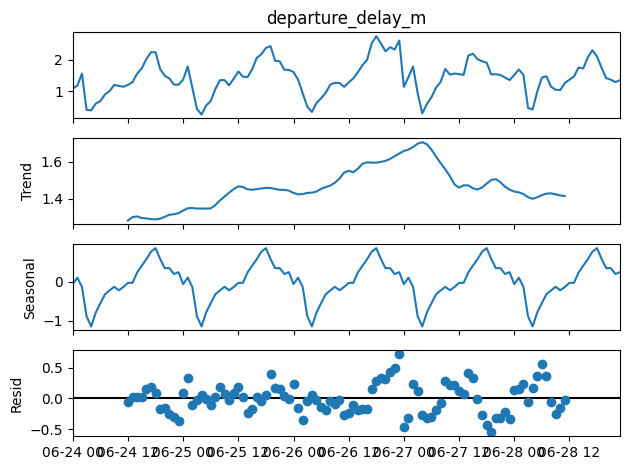

In [6]:
decomposition = seasonal_decompose(tsa['departure_delay_m'], model='additive', period=24)
decomposition.plot()
plt.show()

In [7]:
tsa["departure_delay_m"] = scaler.fit_transform(tsa[["departure_delay_m"]])
tsa.head()

,departure_delay_m,departure_plan_hour
departure_plan_datetime,,
2024-06-24 00:00:00,0.332229,0.0
2024-06-24 01:00:00,0.369475,1.0
2024-06-24 02:00:00,0.521795,2.0
2024-06-24 03:00:00,0.059724,3.0
2024-06-24 04:00:00,0.052778,4.0


In [36]:
from scipy.stats import zscore

statelist = df.state.unique()
frames = {}
for state in statelist:
    frames[state] = df[df["state"] == state]
    frames[state] = frames[state][["departure_plan_datetime","departure_delay_m","departure_plan_hour"]].groupby("departure_plan_datetime").mean()
    frames[state].loc["2024-06-24 15:00:00","departure_delay_m"] = frames[state][frames[state]["departure_plan_hour"] == 15].departure_delay_m.median()
    frames[state].loc["2024-06-24 16:00:00","departure_delay_m"] = frames[state][frames[state]["departure_plan_hour"] == 16].departure_delay_m.median()
    frames[state].loc["2024-06-24 17:00:00","departure_delay_m"] = frames[state][frames[state]["departure_plan_hour"] == 17].departure_delay_m.median()
    frames[state].loc["2024-06-24 18:00:00","departure_delay_m"] = frames[state][frames[state]["departure_plan_hour"] == 18].departure_delay_m.median()
    frames[state].loc["2024-06-24 17:00:00","departure_plan_hour"] = 17.0
    frames[state].loc["2024-06-24 18:00:00","departure_plan_hour"] = 18.0
    # Calculate Z-scores of the 'departure_delay_m' column
    frames[state]['zscore'] = zscore(frames[state]['departure_delay_m'])
    # Identify outliers with Z-score threshold of 3
    outliers = frames[state][np.abs(frames[state]['zscore']) > 3]
    # Replace outliers with the median of the surrounding values
    for index in outliers.index:
        frames[state].at[index, 'departure_delay_m'] = frames[state]['departure_delay_m'].median()
    # Drop the zscore column as it's no longer needed
    frames[state] = frames[state].drop(columns=['zscore'])
    frames[state]['departure_delay_m'] = frames[state]['departure_delay_m'].rolling(window=3).mean()
    frames[state].dropna(inplace=True)
    frames[state].sort_index(inplace=True)
    frames[state]["departure_delay_m"] = scaler.fit_transform(frames[state][["departure_delay_m"]])


In [9]:
result = adfuller(tsa['departure_delay_m'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] < 0.05:
    print("Series is stationary. No differencing needed.")

ADF Statistic: -5.689921324343224
p-value: 8.115587441658474e-07
Critical Values: {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}
Series is stationary. No differencing needed.


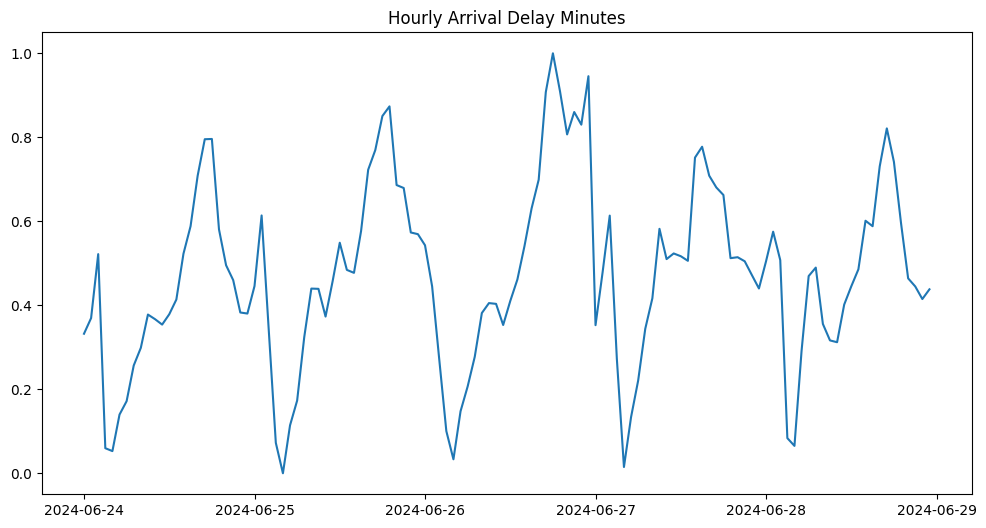

In [10]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(tsa['departure_delay_m'])
plt.title('Hourly Arrival Delay Minutes')
plt.show()

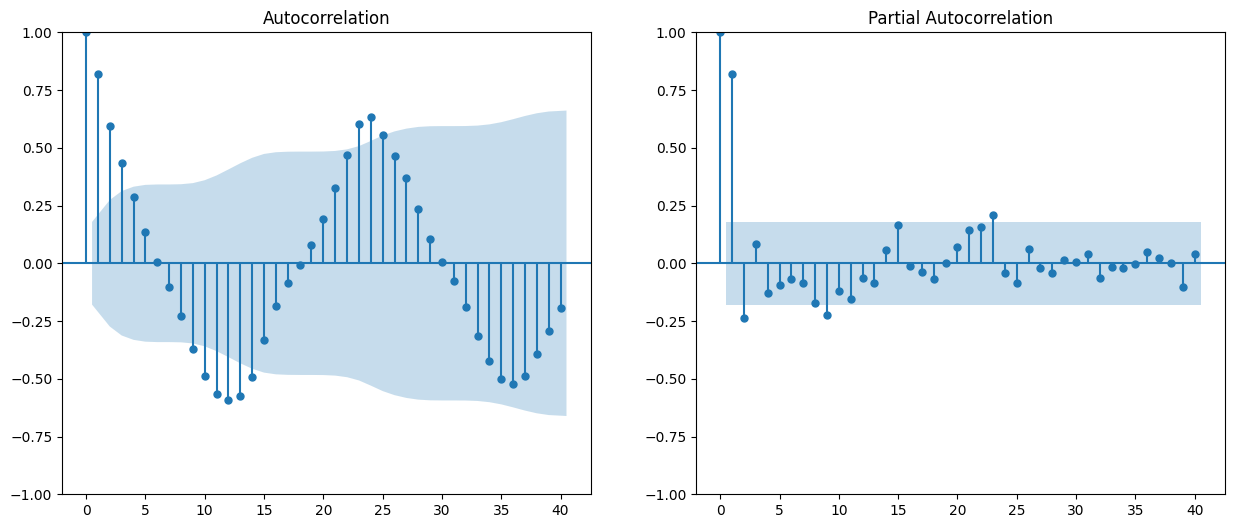

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(tsa['departure_delay_m'], lags=40, ax=axes[0])
plot_pacf(tsa['departure_delay_m'], lags=40, ax=axes[1])
plt.show()

In [12]:
from warnings import filterwarnings
filterwarnings('ignore')

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model
model = SARIMAX(tsa['departure_delay_m'], 
                order=(2, 0, 3), #CHANGE
                seasonal_order=(2, 0, 3, 24), 
                )
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  departure_delay_m   No. Observations:                  120
Model:             SARIMAX(2, 0, 3)x(2, 0, 3, 24)   Log Likelihood                  99.859
Date:                            Wed, 10 Jul 2024   AIC                           -177.719
Time:                                    19:51:04   BIC                           -147.056
Sample:                                06-24-2024   HQIC                          -165.266
                                     - 06-28-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6785      0.961      0.706      0.480      -1.205       2.562
ar.L2          0.2752      0.919   

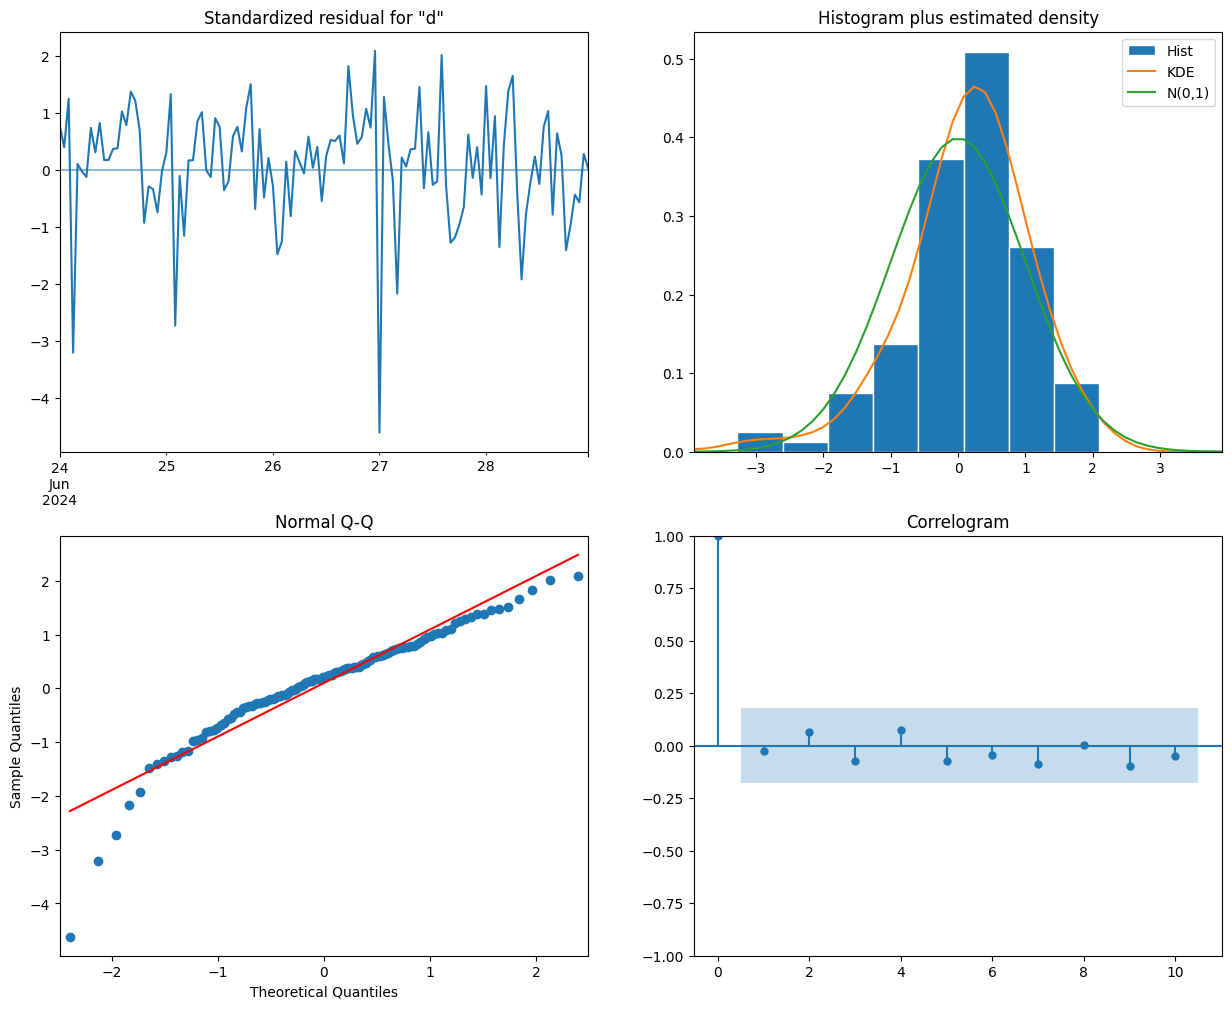

In [14]:
# Diagnostic plots
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

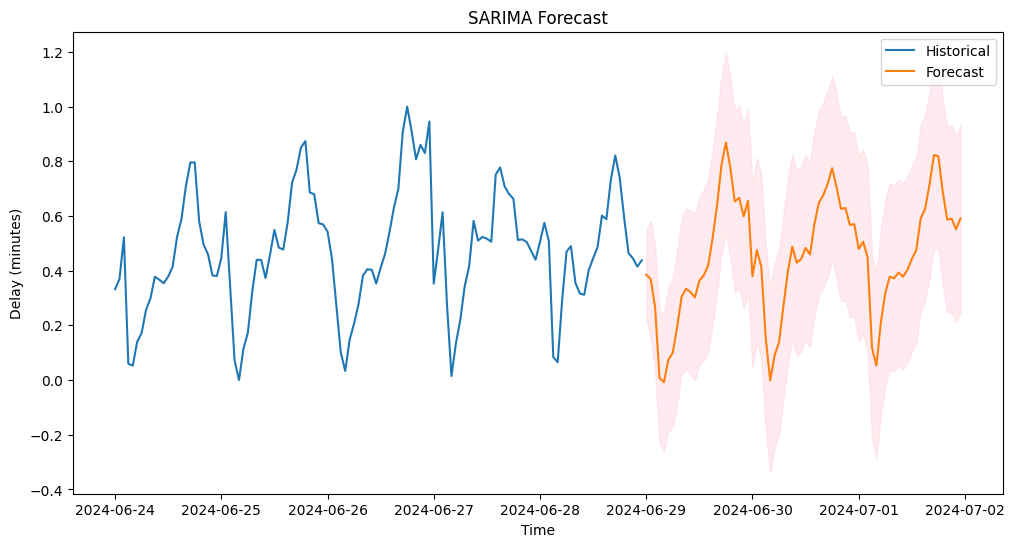

In [15]:
forecast_steps = 72
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=tsa.index[-1], periods=forecast_steps + 1, freq='h')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
confidence_intervals = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(tsa['departure_delay_m'], label='Historical')
plt.plot(forecast_series, label='Forecast')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()

outlier detection
combine the two datasets to one to predict a week
show accuraacy with second dataset

test bundesländer if they follow the pattern

# Searching for Systematic Issues

In [16]:
from warnings import filterwarnings
filterwarnings('ignore')

In [37]:
models = {}

for state, data in frames.items():
    model = SARIMAX(data['departure_delay_m'].head(48), 
                    order=(2, 0, 3), 
                    seasonal_order=(2, 0, 3, 24), 
                    )
    fit = model.fit(disp=False)
    models[state] = fit
    print(f"fitted to {state}")

fitted to Nordrhein-Westfalen
fitted to Baden-Württemberg
fitted to Niedersachsen
fitted to Schleswig-Holstein
fitted to Bayern
fitted to Berlin
fitted to Hamburg
fitted to Rheinland-Pfalz
fitted to Mecklenburg-Vorpommern
fitted to Thüringen
fitted to Sachsen
fitted to Sachsen-Anhalt
fitted to Brandenburg
fitted to Hessen
fitted to Saarland
fitted to Bremen


In [38]:
predictions = {}
for state, data in frames.items():
    predictions[state] = models[state].get_prediction(start=data.index[0], end=data.index[47])
    forecast_steps = data.shape[0]-48
    forecast = models[state].get_forecast(steps=forecast_steps)
    values = np.append(predictions[state].predicted_mean.values,forecast.predicted_mean.values)
    data['predicted'] = values
    data['residuals'] = data['departure_delay_m'] - data['predicted']





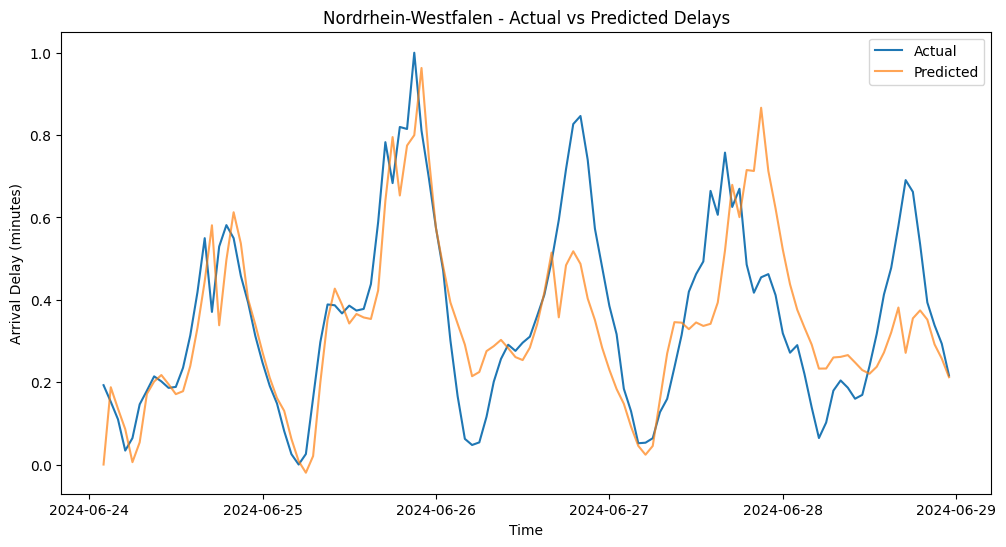

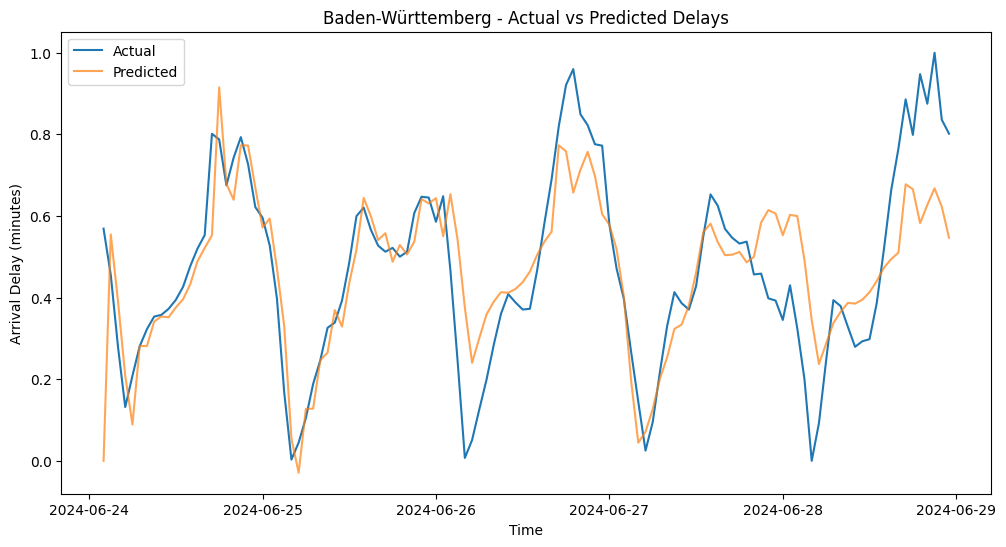

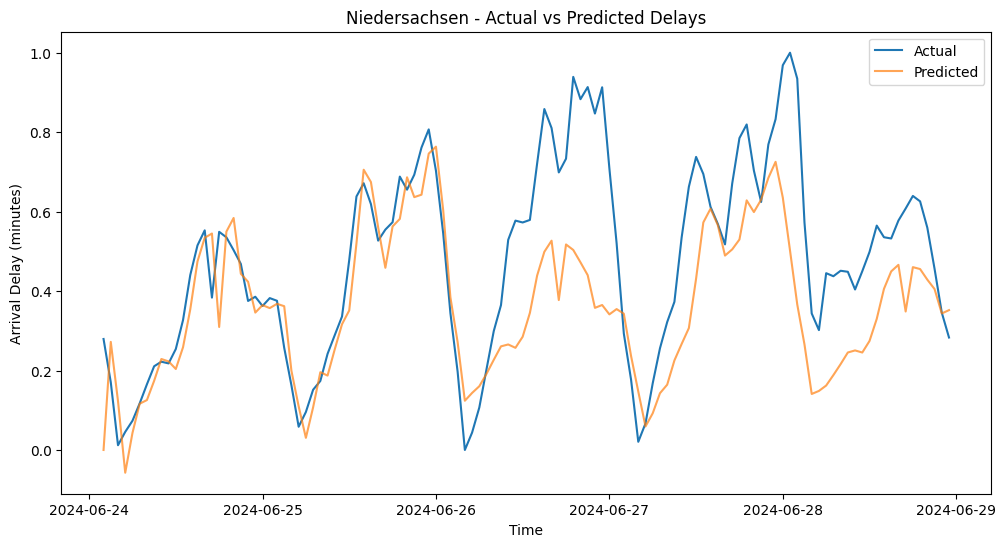

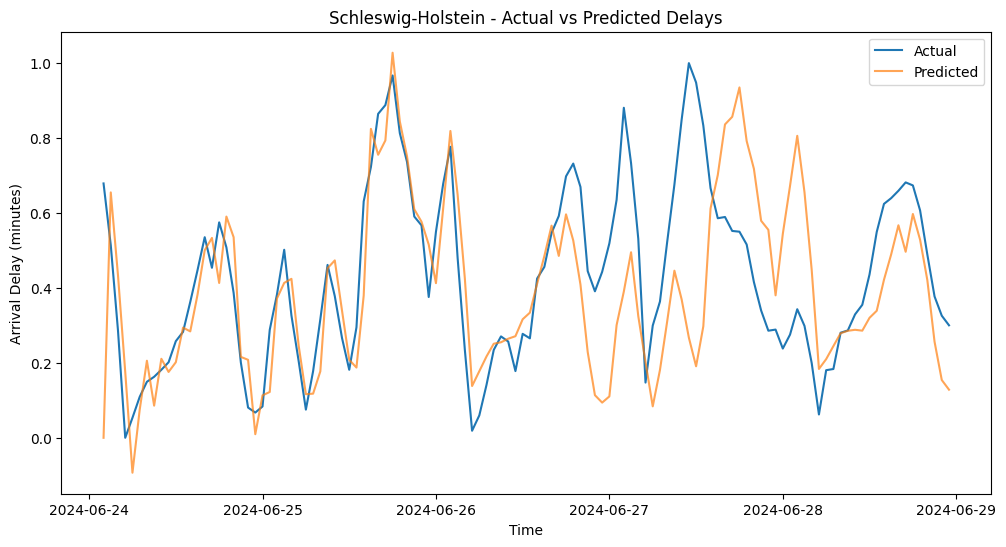

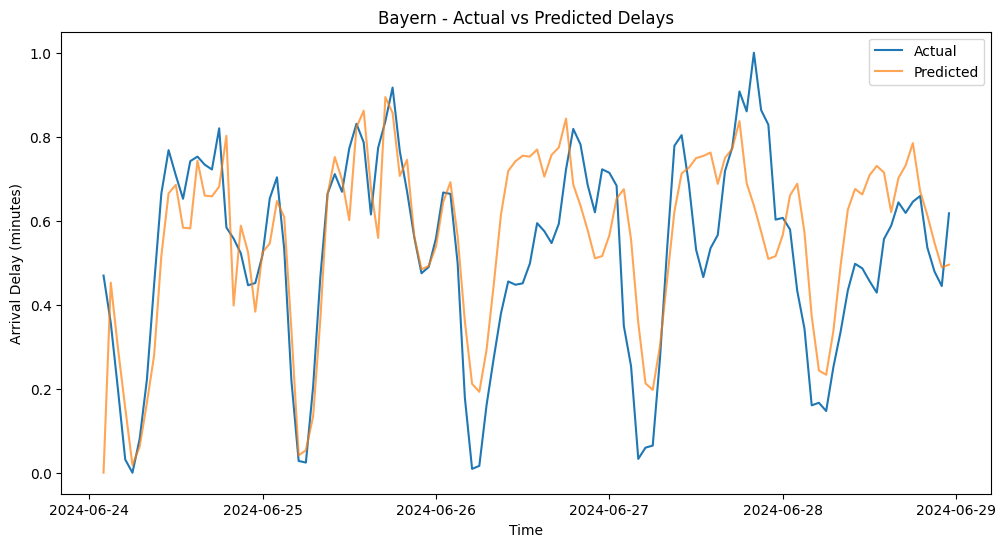

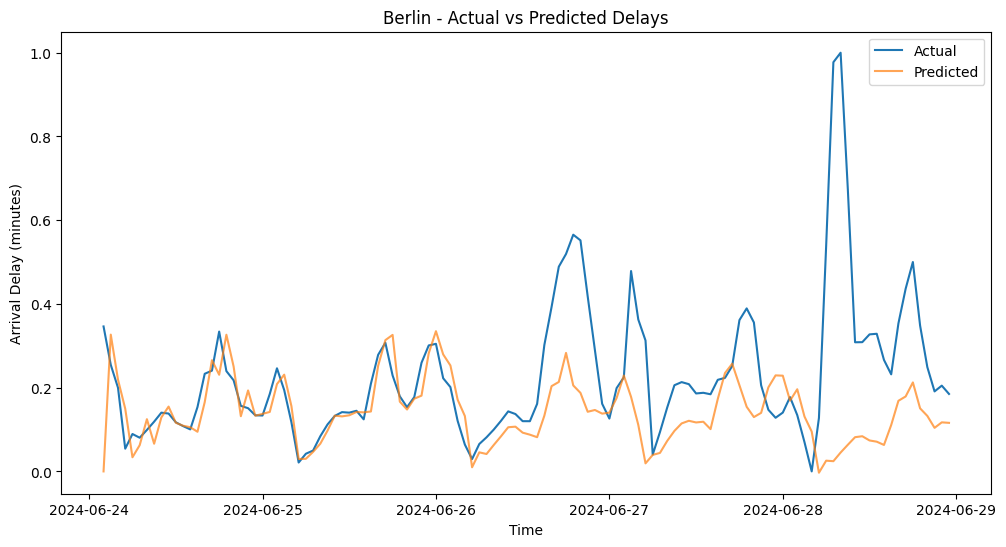

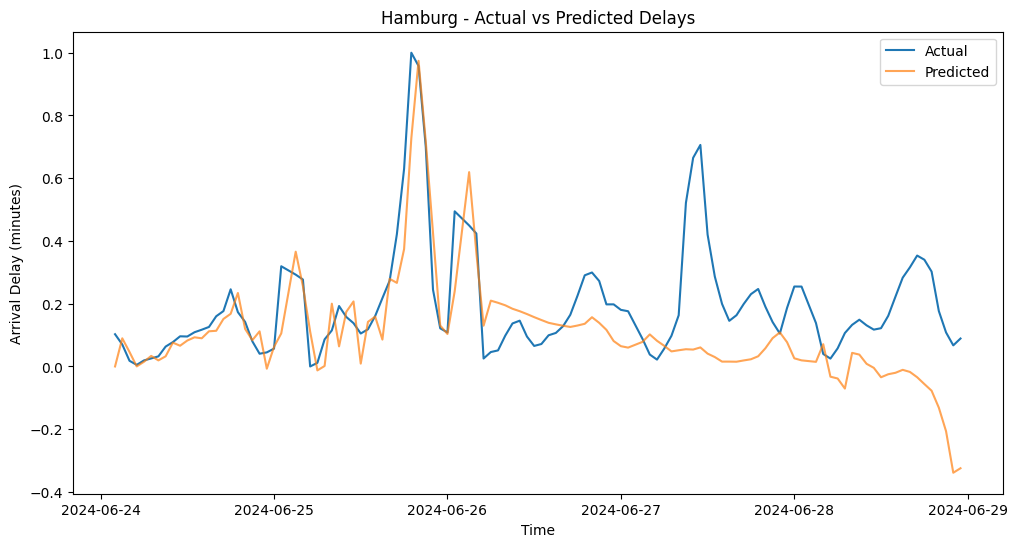

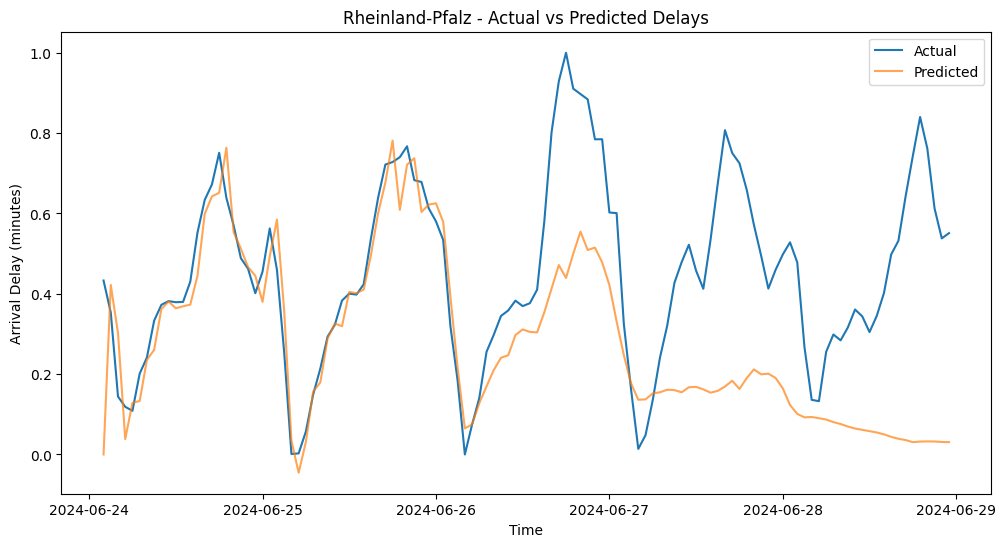

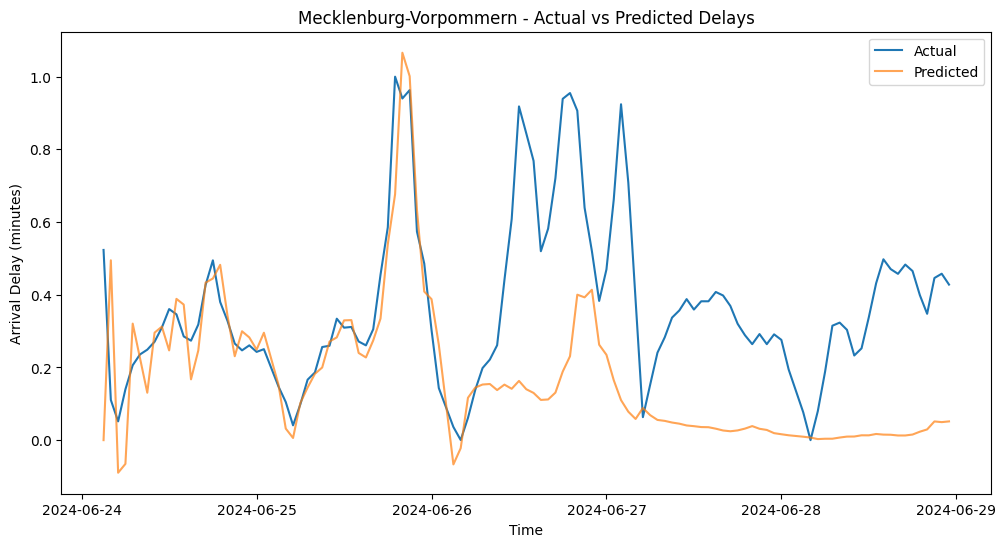

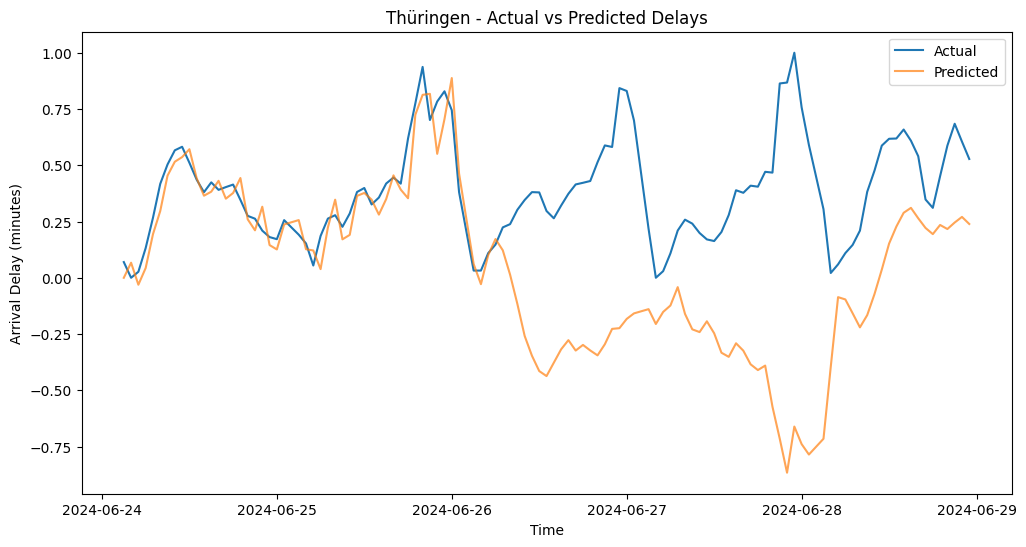

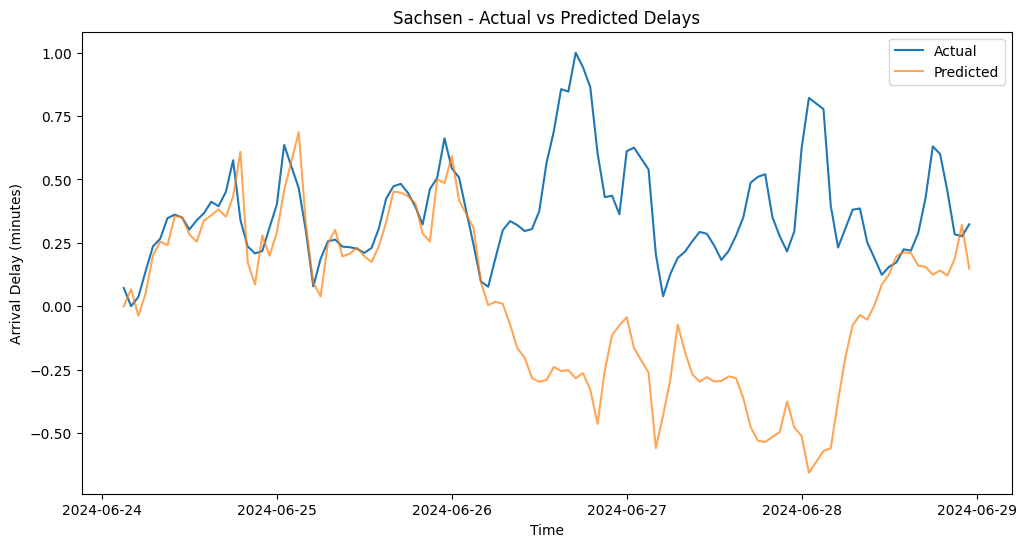

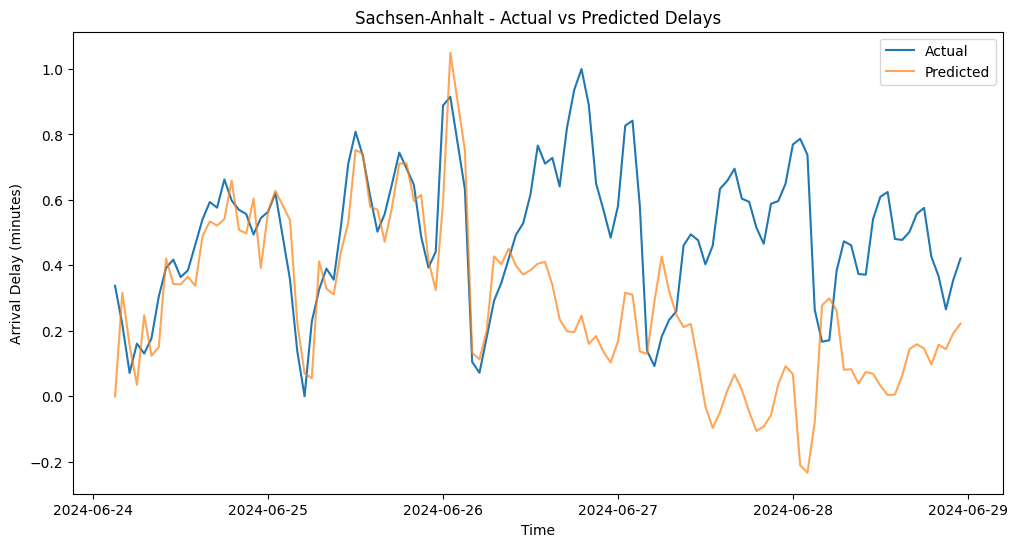

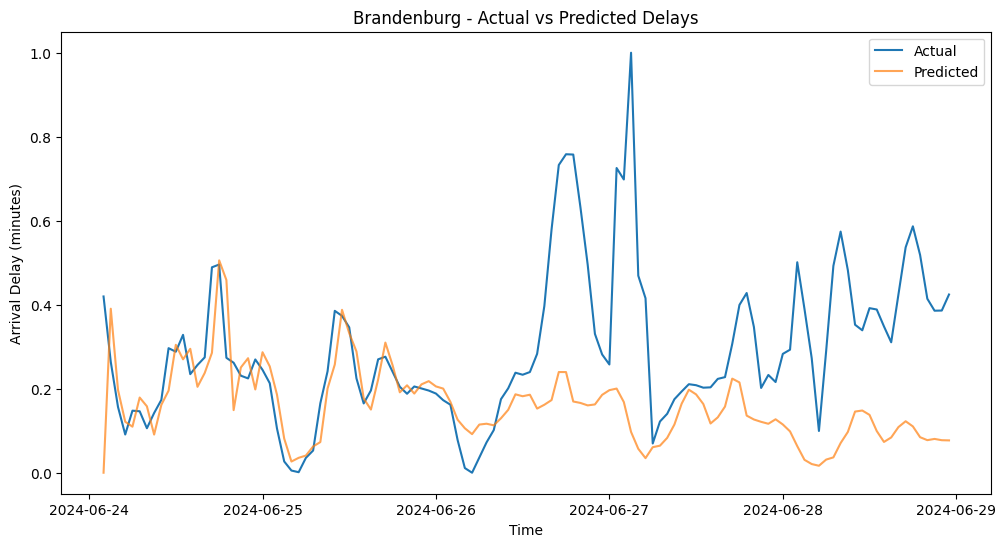

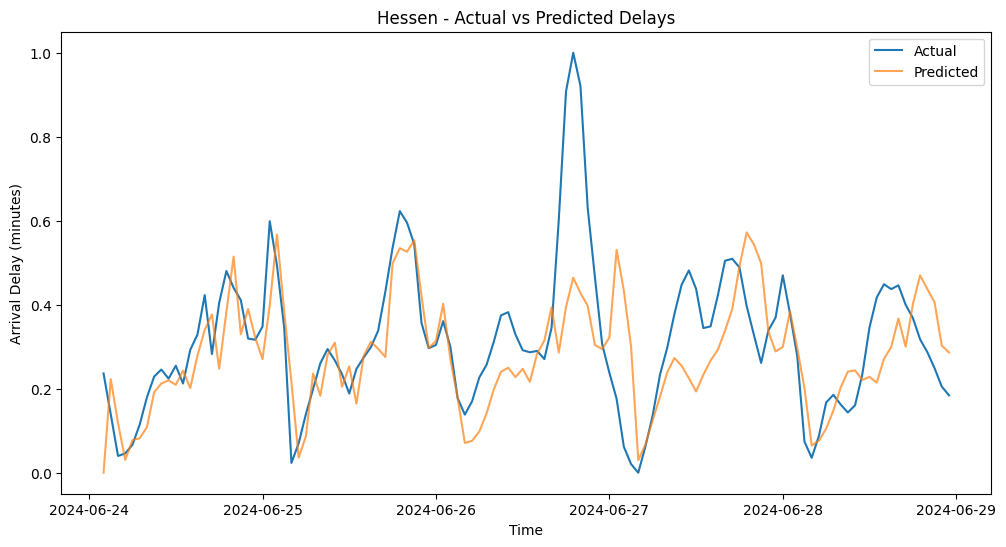

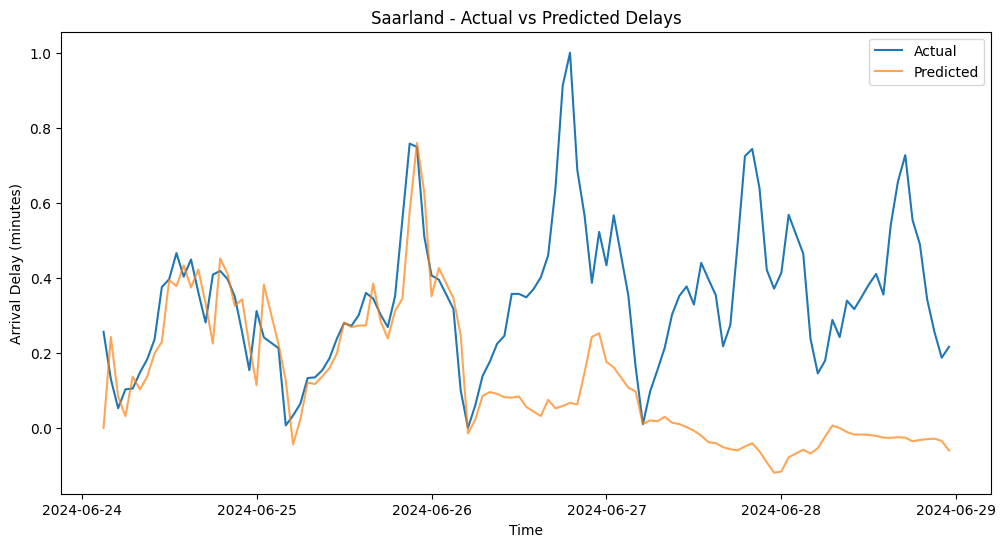

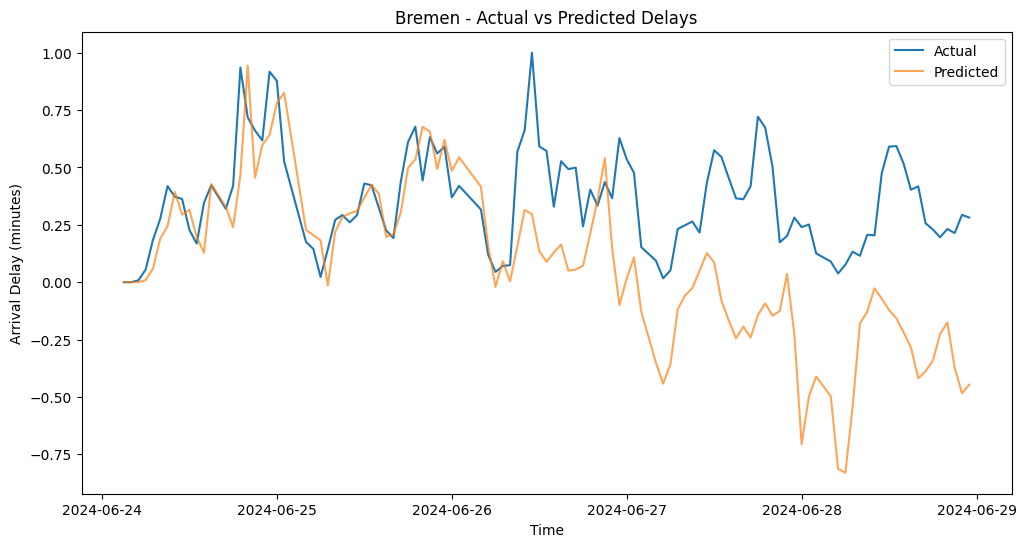

In [39]:
for state, data in frames.items():
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['departure_delay_m'], label='Actual')
    plt.plot(data.index, data['predicted'], label='Predicted', alpha=0.7)
    plt.title(f'{state} - Actual vs Predicted Delays')
    plt.xlabel('Time')
    plt.ylabel('Arrival Delay (minutes)')
    plt.legend()
    plt.show()

In [40]:
comparison = pd.DataFrame(columns=["mae", "rmse"])

for state, data in frames.items():
    residuals = data['residuals']
    mae = residuals.abs().mean()
    rmse = np.sqrt((residuals ** 2).mean())

    comparison.loc[state,"mae"] = mae
    comparison.loc[state,"rmse"] = rmse



In [41]:
comparison.sort_values("rmse")

,mae,rmse
Baden-Württemberg,0.099103,0.139502
Nordrhein-Westfalen,0.108039,0.143647
Hessen,0.101697,0.143789
Bayern,0.126252,0.15726
Hamburg,0.125438,0.179071
Berlin,0.109067,0.190265
Niedersachsen,0.142679,0.193457
Schleswig-Holstein,0.153273,0.213587
Brandenburg,0.158109,0.232904
Rheinland-Pfalz,0.193054,0.273532
